In [1]:
from sklearn.cluster import KMeans
import numpy as np
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
%matplotlib inline
from spectral import kmeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from hdbscan import HDBSCAN
from itertools import permutations

In [2]:
def pfs_(labels,X, cluster_centre):
    sse = np.zeros(np.unique(labels).size)
    for i, label in enumerate(np.unique(labels)):
        sse[i] = ((X[labels == label] - cluster_centre[i])**2).sum()
    sse = sse.sum()
    sst= ((X - X.mean(0))**2).sum()
    r_2 = (sst - sse)/sst
    
    return (r_2 / (np.unique(labels).size - 1)) / ((1 - r_2) / (X.shape[0] - np.unique(labels).size)), r_2

In [3]:
def dbi_(labels, X, cluster_centre):
    
    permutation = permutations(np.unique(labels),2)

    # calculate all inter distances
    s = np.zeros((np.unique(labels).size))
    for label in np.unique(labels):

        s[label] = np.sqrt(((X[labels==label] - cluster_centre[label]) ** 2).sum(1)).mean()
    
    # initiate variables
    pair_i = None
    db = []
    d= []
    
    # calculate the dbi for each permutation and group them up by cluster label
    
    for pair in permutation:
                 
        m_i = np.sqrt(((cluster_centre[pair[0]] - cluster_centre[pair[1]])**2).sum(0))

        r_i = (s[pair[0]] + s[pair[1]]) / m_i
        
        
        # group up permutations (i.e. (1,2) and (1,3), but not (1,2) and (2,1))
        if pair[0] == pair_i or pair_i == None:
            d.append(r_i)         
        
        # get max r_i from db and reinitialize variable for new group of permutations
        else:            
            db.append(max(d)) 
            
            # new group
            d = []
            d.append(r_i)
        
        # update cluster ID that was processed
        pair_i = pair[0]
    
    # calculate DBI from db
    
    return sum(db) / len(db)      

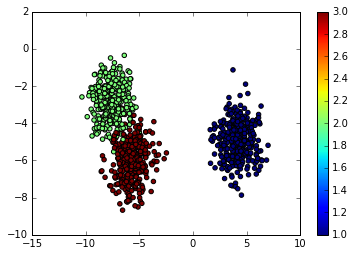

In [4]:
data = make_blobs(1000,2,3)
X = data[0]
y = data[1]
plt.scatter(X[:,0], X[:,1], c = y+1)
plt.colorbar()

In [5]:
pfs = []
r_2 = []
silhouette = []
dbi = []
ratio = []
for cluster in range(2, 20):
    kmeans = KMeans(cluster).fit(X)
    labels = kmeans.predict(X)
    pfs_i, r_2_i = pfs_(labels, X, kmeans.cluster_centers_)
    pfs.append(pfs_i)
    r_2.append(r_2_i)
    silhouette.append(silhouette_score(X, labels))
    dbi.append(dbi_(labels, X, kmeans.cluster_centers_))

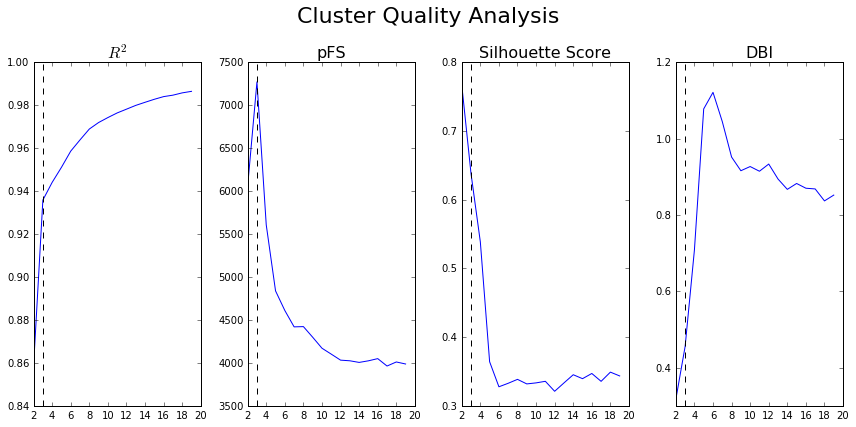

In [6]:
plt.figure(figsize=(12,6))
plt.suptitle('Cluster Quality Analysis', size = 22)
plt.subplot(1,4,1)
plt.title('$R^2$', size=16)
plt.plot(range(2,20), r_2)
plt.axvline(3, linestyle='--', color='k')
plt.subplot(1,4,2)
plt.title('pFS', size=16)
plt.plot(range(2,20), pfs)
plt.axvline(3, linestyle='--', color='k')
plt.subplot(1,4,3)
plt.title('Silhouette Score', size=16)
plt.plot(range(2,20), silhouette)
plt.axvline(3, linestyle='--', color='k')
plt.subplot(1,4,4)
plt.title('DBI', size=16)
plt.plot(range(2,20), dbi)
plt.axvline(3, linestyle='--', color='k')
plt.tight_layout()
plt.subplots_adjust(top=0.85)

In [7]:
def remove_noise(X, labels):
    noise = np.where(labels == -1)
    X = np.delete(X, noise[0],axis=0)
    labels = np.delete(labels, noise[0])
    return X, labels
def compute_centre(X, labels):
    centres = np.zeros((np.unique(labels).size, X.shape[1]))
    for label in np.unique(labels):
        centres[label, :] = X[label==labels].mean(0)
    return centres

In [8]:
pfs = []
r_2 = []
silhouette = []
dbi=[]
for eps in np.linspace(0.1,1,10):
        dbscan = DBSCAN(eps=eps).fit(X)
        labels = dbscan.labels_
        X_i, labels_i = remove_noise(X, labels)
        cluster_centres = compute_centre(X_i, labels_i)
        pfs_i, r_2_i = pfs_(labels_i, X_i, cluster_centres)
        dbi_i = dbi_(labels_i, X_i, cluster_centres)
        sil_i = silhouette_score(X_i, labels_i)
        pfs.append(pfs_i)
        r_2.append(r_2_i)
        silhouette.append(sil_i)
        dbi.append(dbi_i)

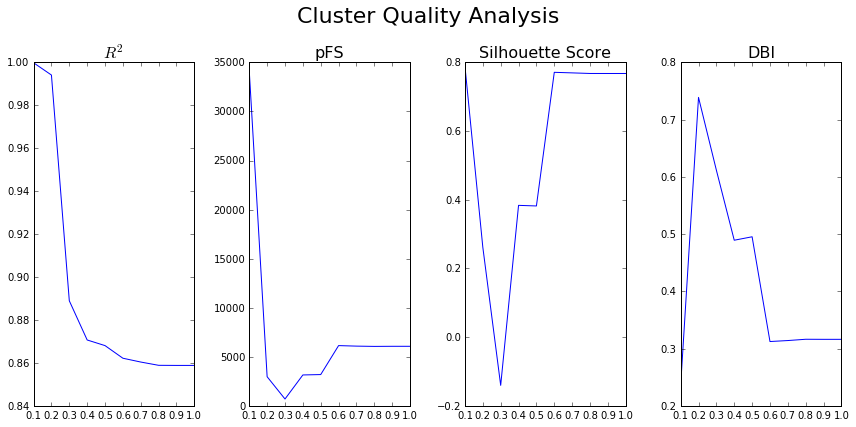

In [9]:
plt.figure(figsize=(12,6))
plt.suptitle('Cluster Quality Analysis', size = 22)
plt.subplot(1,4,1)
plt.title('$R^2$', size=16)
plt.plot(np.linspace(0.1,1,10), r_2)
plt.subplot(1,4,2)
plt.title('pFS', size=16)
plt.plot(np.linspace(0.1,1,10), pfs)
plt.subplot(1,4,3)
plt.title('Silhouette Score', size=16)
plt.plot(np.linspace(0.1,1,10), silhouette)
plt.subplot(1,4,4)
plt.title('DBI', size=16)
plt.plot(np.linspace(0.1,1,10), dbi)
plt.tight_layout()
plt.subplots_adjust(top=0.85)

3183.90606806 0.868044603373


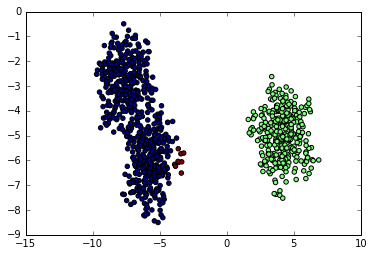

In [10]:
dbscan = DBSCAN(eps=0.5).fit(X)
labels = dbscan.labels_
X_i, labels_i = remove_noise(X, labels)
cluster_centres = compute_centre(X_i, labels_i)
plt.scatter(X_i[:,0], X_i[:,1], c=labels_i)
pfs_i, r_2_i = pfs_(labels_i, X_i, cluster_centres)

print pfs_i, r_2_i

-231.969295979 -2.31898093938 0.351541244103


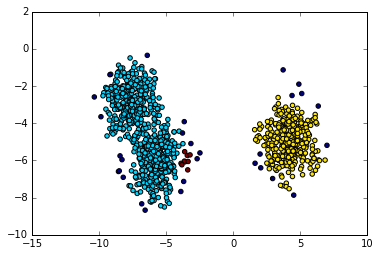

In [11]:
dbscan = DBSCAN(eps=0.5).fit(X)
labels = dbscan.labels_
cluster_centres = compute_centre(X, labels)
plt.scatter(X[:,0], X[:,1], c=labels)
pfs_i, r_2_i = pfs_(labels, X, cluster_centres)

print pfs_i, r_2_i, silhouette_score(X, labels) 

6059.56735412 0.85859150187 0.76739892034


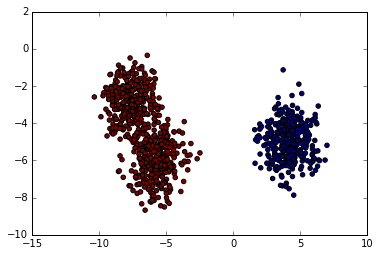

In [12]:
hdbscan = HDBSCAN().fit(X)
labels = hdbscan.labels_
X_i, labels_i = remove_noise(X, labels)
cluster_centres = compute_centre(X_i, labels_i)
plt.scatter(X_i[:,0], X_i[:,1], c=labels_i)
pfs_i, r_2_i = pfs_(labels_i, X_i, cluster_centres)

print pfs_i, r_2_i, silhouette_score(X_i, labels_i) 

6059.56735412 0.85859150187 0.76739892034


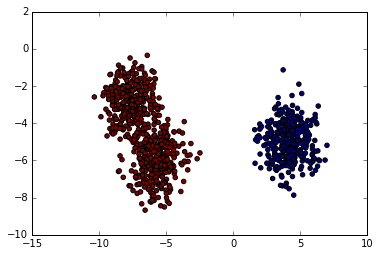

In [13]:
hdbscan = HDBSCAN().fit(X)
labels = hdbscan.labels_
#X_i, labels_i = remove_noise(X, labels)
cluster_centres = compute_centre(X, labels)
plt.scatter(X[:,0], X[:,1], c=labels)
pfs_i, r_2_i = pfs_(labels, X, cluster_centres)

print pfs_i, r_2_i, silhouette_score(X, labels) 

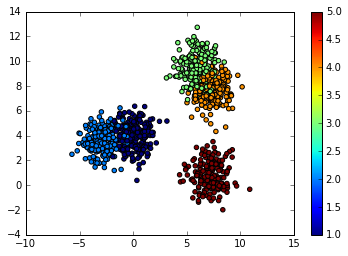

In [14]:
data = make_blobs(1000,2,5)
X = data[0]
y = data[1]
plt.scatter(X[:,0], X[:,1], c = y+1)
plt.colorbar()

In [15]:
pfs = []
r_2 = []
silhouette = []
dbi=[]
x_range = range(2,51)
for x in x_range:
    dbscan = HDBSCAN(x).fit(X)
    labels = dbscan.labels_
    X_i, labels_i = remove_noise(X, labels)
    cluster_centres = compute_centre(X_i, labels_i)
    pfs_i, r_2_i = pfs_(labels_i, X_i, cluster_centres)
    dbi_i = dbi_(labels_i, X_i, cluster_centres)
    sil_i = silhouette_score(X_i, labels_i)
    pfs.append(pfs_i)
    r_2.append(r_2_i)
    silhouette.append(sil_i)
    dbi.append(dbi_i)

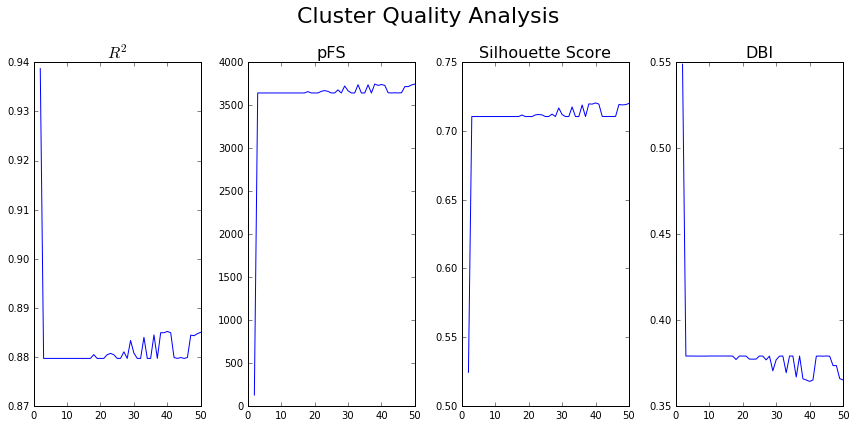

In [16]:
plt.figure(figsize=(12,6))
plt.suptitle('Cluster Quality Analysis', size = 22)
plt.subplot(1,4,1)
plt.title('$R^2$', size=16)
plt.plot(x_range, r_2)
plt.subplot(1,4,2)
plt.title('pFS', size=16)
plt.plot(x_range, pfs)
plt.subplot(1,4,3)
plt.title('Silhouette Score', size=16)
plt.plot(x_range, silhouette)
plt.subplot(1,4,4)
plt.title('DBI', size=16)
plt.plot(x_range, dbi)
plt.tight_layout()
plt.subplots_adjust(top=0.85)

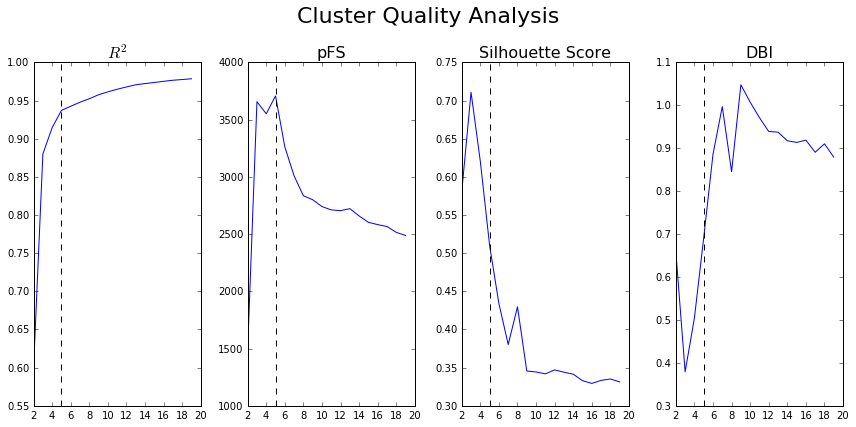

In [17]:
pfs = []
r_2 = []
silhouette = []
dbi = []
for cluster in range(2, 20):
    kmeans = KMeans(cluster).fit(X)
    labels = kmeans.predict(X)
    pfs_i, ratio_i = pfs_(labels, X, kmeans.cluster_centers_)
    pfs.append(pfs_i)
    r_2.append(ratio_i)
    silhouette.append(silhouette_score(X, labels))
    dbi.append(dbi_(labels, X, kmeans.cluster_centers_))
plt.figure(figsize=(12,6))
plt.suptitle('Cluster Quality Analysis', size = 22)
plt.subplot(1,4,1)
plt.title('$R^2$', size=16)
plt.plot(range(2,20), r_2)
plt.axvline(5, linestyle='--', color='k')
plt.subplot(1,4,2)
plt.title('pFS', size=16)
plt.plot(range(2,20), pfs)
plt.axvline(5, linestyle='--', color='k')
plt.subplot(1,4,3)
plt.title('Silhouette Score', size=16)
plt.plot(range(2,20), silhouette)
plt.axvline(5, linestyle='--', color='k')
plt.subplot(1,4,4)
plt.title('DBI', size=16)
plt.plot(range(2,20), dbi)
plt.axvline(5, linestyle='--', color='k')
plt.tight_layout()
plt.subplots_adjust(top=0.85)

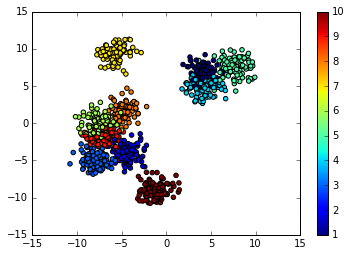

In [18]:
data = make_blobs(1000,2,10)
X = data[0]
y = data[1]
plt.scatter(X[:,0], X[:,1], c = y+1)
plt.colorbar()

In [19]:
pfs = []
r_2 = []
silhouette = []
dbi = []
for cluster in range(2, 20):
    kmeans = KMeans(cluster).fit(X)
    labels = kmeans.predict(X)
    pfs_i, ratio_i = pfs_(labels, X, kmeans.cluster_centers_)
    pfs.append(pfs_i)
    r_2.append(ratio_i)
    silhouette.append(silhouette_score(X, labels))
    dbi.append(dbi_(labels, X, kmeans.cluster_centers_))

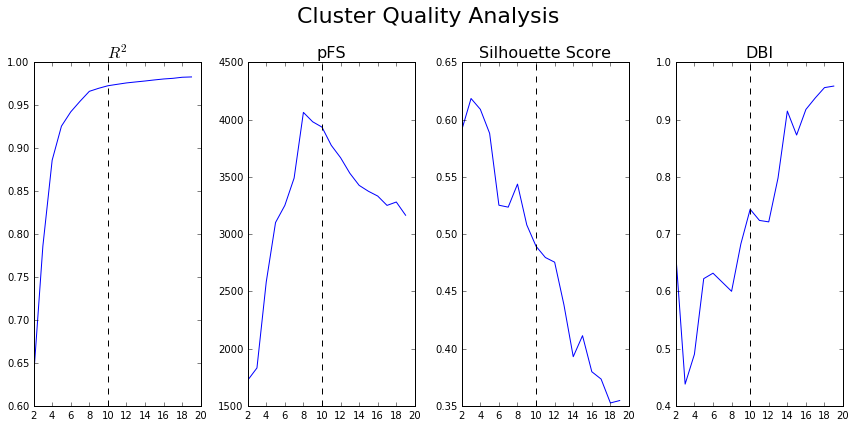

In [20]:
plt.figure(figsize=(12,6))
plt.suptitle('Cluster Quality Analysis', size = 22)
plt.subplot(1,4,1)
plt.title('$R^2$', size=16)
plt.plot(range(2,20), r_2)
plt.axvline(10, linestyle='--', color='k')
plt.subplot(1,4,2)
plt.title('pFS', size=16)
plt.plot(range(2,20), pfs)
plt.axvline(10, linestyle='--', color='k')
plt.subplot(1,4,3)
plt.title('Silhouette Score', size=16)
plt.plot(range(2,20), silhouette)
plt.axvline(10, linestyle='--', color='k')
plt.subplot(1,4,4)
plt.title('DBI', size=16)
plt.plot(range(2,20), dbi)
plt.axvline(10, linestyle='--', color='k')
plt.tight_layout()
plt.subplots_adjust(top=0.85)

In [21]:
pfs = []
r_2 = []
silhouette = []
for eps in np.linspace(0.1,1,10):
    try:
        dbscan = DBSCAN(eps=eps).fit(X)
        labels = dbscan.labels_
        X_i, labels_i = remove_noise(X, labels)
        cluster_centres = compute_centre(X_i, labels_i)
        pfs_i, r_2_i = pfs_(labels_i, X_i, cluster_centres)
        sil_i = silhouette_score(X_i, labels_i)
        pfs.append(pfs_i)
        r_2.append(r_2_i)
        silhouette.append(sil_i)
    except:
        pfs.append(0)
        r_2.append(0)
        silhouette.append(0)

C:\Users\Gil\Anaconda2\envs\MDanalysis\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\Users\Gil\Anaconda2\envs\MDanalysis\lib\site-packages\numpy\core\_methods.py:68: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\Gil\Anaconda2\envs\MDanalysis\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: invalid value encountered in double_scalars


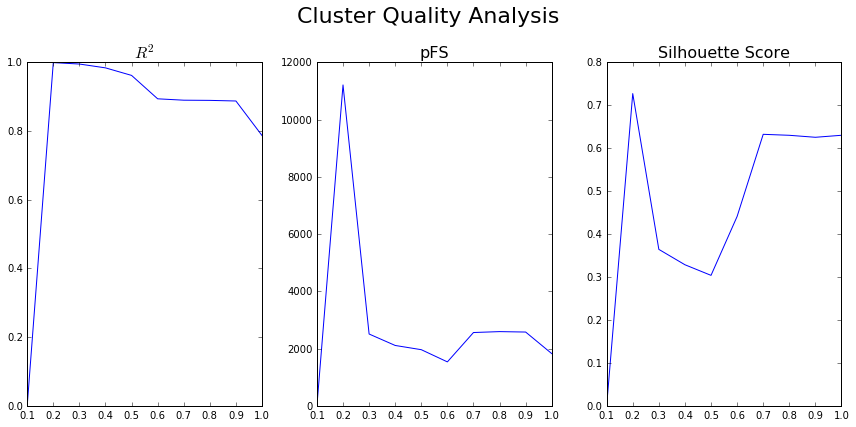

In [22]:
plt.figure(figsize=(12,6))
plt.suptitle('Cluster Quality Analysis', size = 22)
plt.subplot(1,3,1)
plt.title('$R^2$', size=16)
plt.plot(np.linspace(0.1,1,10), r_2)
plt.subplot(1,3,2)
plt.title('pFS', size=16)
plt.plot(np.linspace(0.1,1,10), pfs)
plt.subplot(1,3,3)
plt.title('Silhouette Score', size=16)
plt.plot(np.linspace(0.1,1,10), silhouette)
plt.tight_layout()
plt.subplots_adjust(top=0.85)

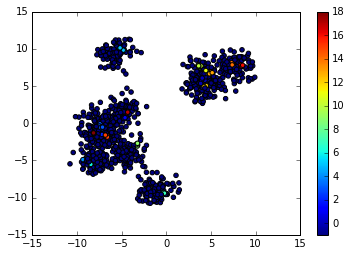

In [23]:
dbscan = DBSCAN(eps=0.2).fit(X)
labels = dbscan.labels_
plt.scatter(X[:,0], X[:,1],c=labels)
plt.colorbar()

## Increase feature space

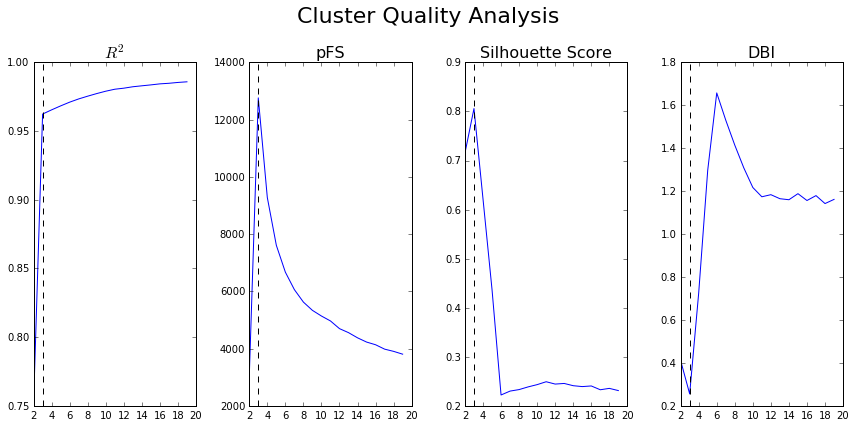

In [24]:
data = make_blobs(1000,3,3)
X = data[0]
y = data[1]
pfs = []
r_2 = []
silhouette = []
dbi = []
for cluster in range(2, 20):
    kmeans = KMeans(cluster).fit(X)
    labels = kmeans.predict(X)
    pfs_i, ratio_i = pfs_(labels, X, kmeans.cluster_centers_)
    pfs.append(pfs_i)
    r_2.append(ratio_i)
    silhouette.append(silhouette_score(X, labels))
    dbi.append(dbi_(labels, X, kmeans.cluster_centers_))
plt.figure(figsize=(12,6))
plt.suptitle('Cluster Quality Analysis', size = 22)
plt.subplot(1,4,1)
plt.title('$R^2$', size=16)
plt.plot(range(2,20), r_2)
plt.axvline(3, linestyle='--', color='k')
plt.subplot(1,4,2)
plt.title('pFS', size=16)
plt.plot(range(2,20), pfs)
plt.axvline(3, linestyle='--', color='k')
plt.subplot(1,4,3)
plt.title('Silhouette Score', size=16)
plt.plot(range(2,20), silhouette)
plt.axvline(3, linestyle='--', color='k')
plt.subplot(1,4,4)
plt.title('DBI', size=16)
plt.plot(range(2,20), dbi)
plt.axvline(3, linestyle='--', color='k')
plt.tight_layout()
plt.subplots_adjust(top=0.85)

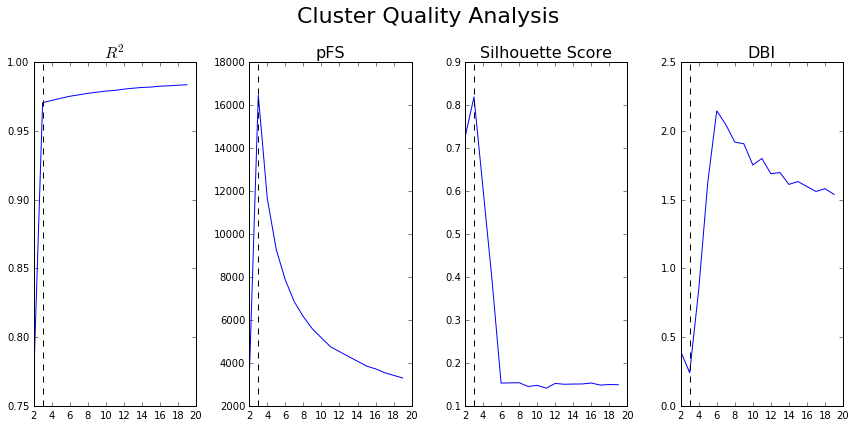

In [25]:
data = make_blobs(1000,5,3)
X = data[0]
y = data[1]
pfs = []
r_2 = []
silhouette = []
dbi = []
for cluster in range(2, 20):
    kmeans = KMeans(cluster).fit(X)
    labels = kmeans.predict(X)
    pfs_i, ratio_i = pfs_(labels, X, kmeans.cluster_centers_)
    pfs.append(pfs_i)
    r_2.append(ratio_i)
    silhouette.append(silhouette_score(X, labels))
    dbi.append(dbi_(labels, X, kmeans.cluster_centers_))
plt.figure(figsize=(12,6))
plt.suptitle('Cluster Quality Analysis', size = 22)
plt.subplot(1,4,1)
plt.title('$R^2$', size=16)
plt.plot(range(2,20), r_2)
plt.axvline(3, linestyle='--', color='k')
plt.subplot(1,4,2)
plt.title('pFS', size=16)
plt.plot(range(2,20), pfs)
plt.axvline(3, linestyle='--', color='k')
plt.subplot(1,4,3)
plt.title('Silhouette Score', size=16)
plt.plot(range(2,20), silhouette)
plt.axvline(3, linestyle='--', color='k')
plt.subplot(1,4,4)
plt.title('DBI', size=16)
plt.plot(range(2,20), dbi)
plt.axvline(3, linestyle='--', color='k')
plt.tight_layout()
plt.subplots_adjust(top=0.85)

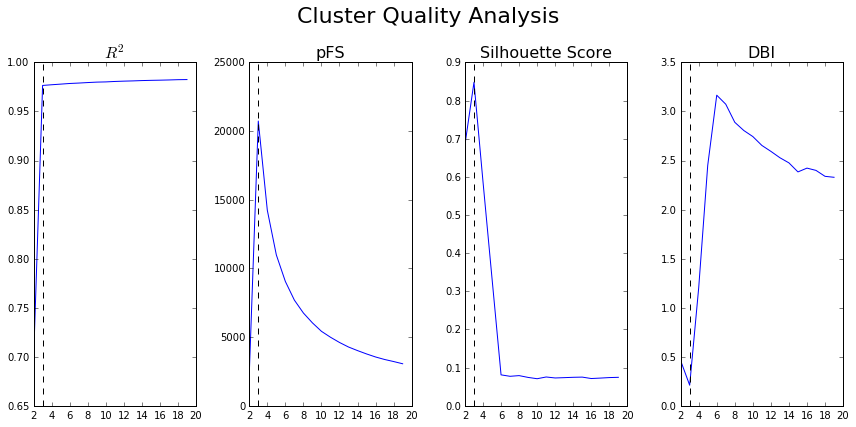

In [26]:
data = make_blobs(1000,10,3)
X = data[0]
y = data[1]
pfs = []
r_2 = []
silhouette = []
dbi = []
for cluster in range(2, 20):
    kmeans = KMeans(cluster).fit(X)
    labels = kmeans.predict(X)
    pfs_i, ratio_i = pfs_(labels, X, kmeans.cluster_centers_)
    pfs.append(pfs_i)
    r_2.append(ratio_i)
    silhouette.append(silhouette_score(X, labels))
    dbi.append(dbi_(labels, X, kmeans.cluster_centers_))
plt.figure(figsize=(12,6))
plt.suptitle('Cluster Quality Analysis', size = 22)
plt.subplot(1,4,1)
plt.title('$R^2$', size=16)
plt.plot(range(2,20), r_2)
plt.axvline(3, linestyle='--', color='k')
plt.subplot(1,4,2)
plt.title('pFS', size=16)
plt.plot(range(2,20), pfs)
plt.axvline(3, linestyle='--', color='k')
plt.subplot(1,4,3)
plt.title('Silhouette Score', size=16)
plt.plot(range(2,20), silhouette)
plt.axvline(3, linestyle='--', color='k')
plt.subplot(1,4,4)
plt.title('DBI', size=16)
plt.plot(range(2,20), dbi)
plt.axvline(3, linestyle='--', color='k')
plt.tight_layout()
plt.subplots_adjust(top=0.85)

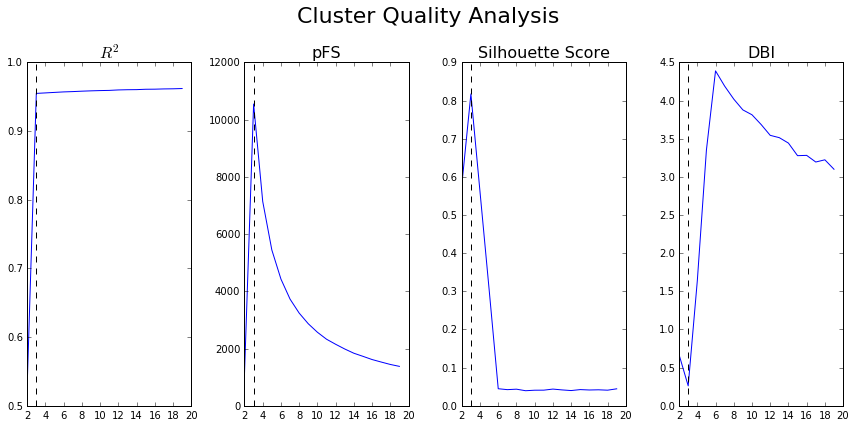

In [27]:
data = make_blobs(1000,20,3)
X = data[0]
y = data[1]
pfs = []
r_2 = []
silhouette = []
dbi = []
for cluster in range(2, 20):
    kmeans = KMeans(cluster).fit(X)
    labels = kmeans.predict(X)
    pfs_i, ratio_i = pfs_(labels, X, kmeans.cluster_centers_)
    pfs.append(pfs_i)
    r_2.append(ratio_i)
    silhouette.append(silhouette_score(X, labels))
    dbi.append(dbi_(labels, X, kmeans.cluster_centers_))
plt.figure(figsize=(12,6))
plt.suptitle('Cluster Quality Analysis', size = 22)
plt.subplot(1,4,1)
plt.title('$R^2$', size=16)
plt.plot(range(2,20), r_2)
plt.axvline(3, linestyle='--', color='k')
plt.subplot(1,4,2)
plt.title('pFS', size=16)
plt.plot(range(2,20), pfs)
plt.axvline(3, linestyle='--', color='k')
plt.subplot(1,4,3)
plt.title('Silhouette Score', size=16)
plt.plot(range(2,20), silhouette)
plt.axvline(3, linestyle='--', color='k')
plt.subplot(1,4,4)
plt.title('DBI', size=16)
plt.plot(range(2,20), dbi)
plt.axvline(3, linestyle='--', color='k')
plt.tight_layout()
plt.subplots_adjust(top=0.85)

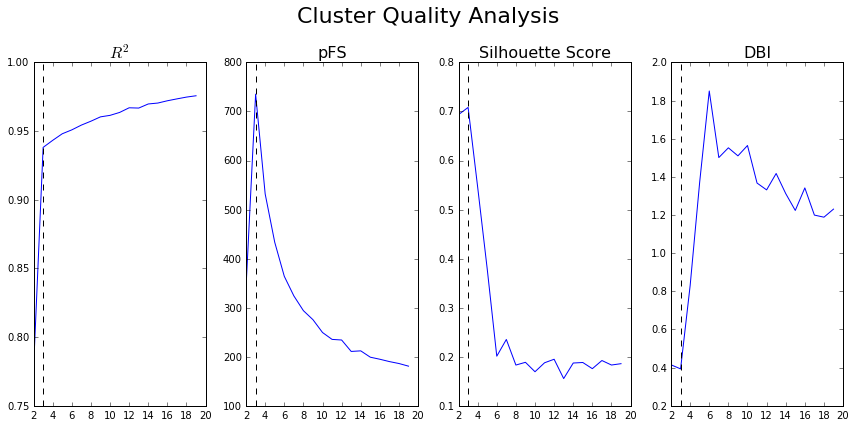

In [28]:
data = make_blobs(100,5,3)
X = data[0]
y = data[1]
pfs = []
r_2 = []
silhouette = []
dbi = []
for cluster in range(2, 20):
    kmeans = KMeans(cluster).fit(X)
    labels = kmeans.predict(X)
    pfs_i, ratio_i = pfs_(labels, X, kmeans.cluster_centers_)
    pfs.append(pfs_i)
    r_2.append(ratio_i)
    silhouette.append(silhouette_score(X, labels))
    dbi.append(dbi_(labels, X, kmeans.cluster_centers_))
plt.figure(figsize=(12,6))
plt.suptitle('Cluster Quality Analysis', size = 22)
plt.subplot(1,4,1)
plt.title('$R^2$', size=16)
plt.plot(range(2,20), r_2)
plt.axvline(3, linestyle='--', color='k')
plt.subplot(1,4,2)
plt.title('pFS', size=16)
plt.plot(range(2,20), pfs)
plt.axvline(3, linestyle='--', color='k')
plt.subplot(1,4,3)
plt.title('Silhouette Score', size=16)
plt.plot(range(2,20), silhouette)
plt.axvline(3, linestyle='--', color='k')
plt.subplot(1,4,4)
plt.title('DBI', size=16)
plt.plot(range(2,20), dbi)
plt.axvline(3, linestyle='--', color='k')
plt.tight_layout()
plt.subplots_adjust(top=0.85)